In [1]:
import os
import argparse
from src.dataset import *
from src.model import SlotAttentionAutoEncoder
from tqdm import tqdm
import time, math
import json
import torch
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INFO: Using numpy backend


In [2]:
# Hyperparameters.
config = '/vol/biomedic3/agk21/testEigenSlots2/LOGSBSA-Baseline/ObjectDiscovery/clevrhans3Gumble/exp-parameters.json'
exp_arguments = json.load(open(config, 'r'))
print(exp_arguments)

{'model_dir': '/vol/biomedic3/agk21/testEigenSlots2/LOGSBSA-Baseline/ObjectDiscovery/clevrhans3Gumble', 'exp_name': 'clevrhans3Gumble', 'seed': 0, 'nunique_objects': 16, 'dataset_name': 'clevr', 'variant': 'hans3', 'img_size': 64, 'kernel_size': 5, 'encoder_res': 8, 'decoder_res': 8, 'num_slots': 7, 'num_iterations': 5, 'hid_dim': 64, 'max_slots': 19, 'quantize': True, 'cosine': False, 'cb_decay': 0.999, 'cb_qk': True, 'eigen_quantizer': True, 'restart_cbstats': False, 'gumble': True, 'temperature': 2.0, 'kld_scale': 1.0, 'batch_size': 16, 'learning_rate': 0.0004, 'num_epochs': 1000, 'num_workers': 4, 'implicit': False, 'overlap_weightage': 0.0, 'warmup_steps': 10000, 'decay_rate': 0.5, 'decay_steps': 100000, 'data_root': '/vol/biomedic2/agk21/PhDLogs/datasets/CLEVR/CLEVR-Hans3'}


In [3]:
resolution = (exp_arguments['img_size'], exp_arguments['img_size'])
model = SlotAttentionAutoEncoder(resolution, 
                                exp_arguments['num_slots'], 
                                exp_arguments['num_iterations'], 
                                exp_arguments['hid_dim'],
                                exp_arguments['max_slots'],
                                exp_arguments['nunique_objects'],
                                exp_arguments['quantize'],
                                exp_arguments['cosine'],
                                exp_arguments['cb_decay'],
                                exp_arguments['encoder_res'],
                                exp_arguments['decoder_res'],
                                exp_arguments['kernel_size'],
                                exp_arguments['cb_qk'],
                                exp_arguments['eigen_quantizer'],
                                exp_arguments['restart_cbstats'],
                                exp_arguments['implicit'],
                                exp_arguments['gumble'],
                                exp_arguments['temperature'],
                                exp_arguments['kld_scale']).to(device)

ckpt=torch.load(os.path.join(exp_arguments['model_dir'], 'discovery_best.pth' ))
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

In [4]:
test_set = DataGenerator(root=exp_arguments['data_root'], 
                            mode='test', 
                            resolution=resolution)
test_set = torch.utils.data.DataLoader(test_set, batch_size=1,
                            shuffle=True, num_workers=4, drop_last=True)


In [5]:
import matplotlib.pyplot as plt
from PIL import Image as Image, ImageEnhance

def plot(image, recon_combined, recons, masks, cbidxs, num_slots=7):
    plt.clf()
    fig, ax = plt.subplots(1, num_slots + 2, figsize=(5*( num_slots + 2), 5))
    image = image.squeeze(0)
    recon_combined = recon_combined.squeeze(0)
    recons = recons.squeeze(0)
    masks = masks.squeeze(0)
    cbidxs = cbidxs.squeeze(0)
    image = image.permute(1,2,0).cpu().numpy()
    recon_combined = recon_combined.permute(1,2,0)
    recon_combined = recon_combined.cpu().detach().numpy()
    recons = recons.cpu().detach().numpy()
    masks = masks.cpu().detach().numpy()
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[1].imshow(recon_combined)
    ax[1].set_title('Recon.')
    for i in range(num_slots):
        picture = recons[i]* masks[i] + (1 - masks[i])
        ax[i + 2].imshow(picture)
        ax[i + 2].set_title(f'S:{i}-CB:{cbidxs[i]}')
    for i in range(len(ax)):
        ax[i].grid(False)
        ax[i].axis('off')
        
    plt.show()

<Figure size 432x288 with 0 Axes>

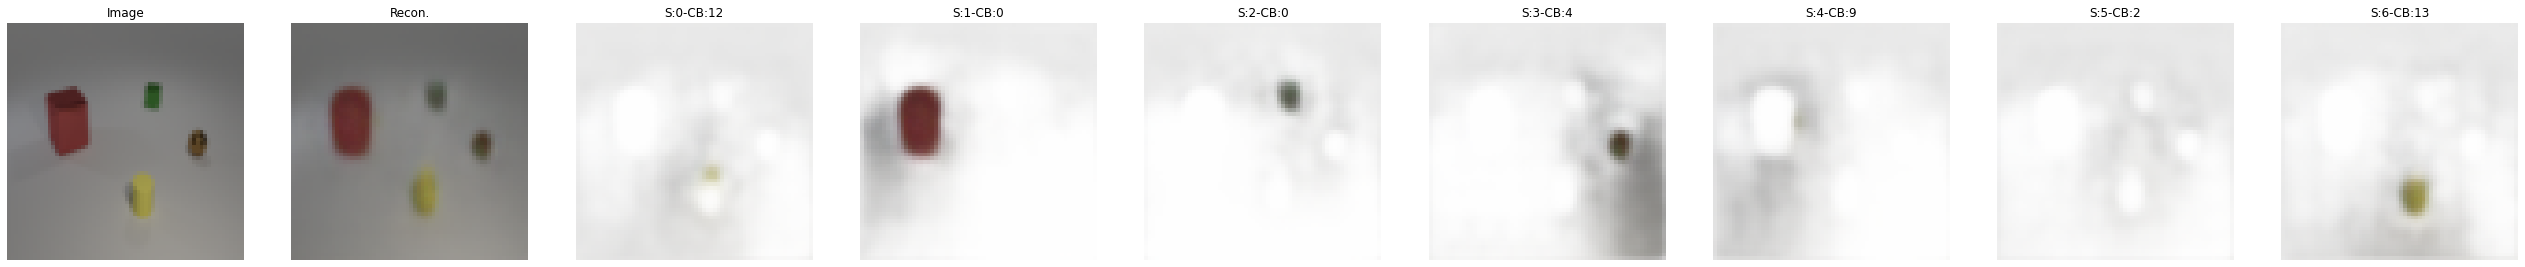

In [6]:
image = next(iter(test_set))
image = image['image']
image = image.to(device)
recon_combined, recons, masks, slots, cbidxs, qloss, perplexity = model(image)
plot(image, recon_combined, recons, masks, cbidxs, num_slots=exp_arguments['num_slots'])
    

In [7]:
cbidxs

tensor([[12,  0,  0,  4,  9,  2, 13]], device='cuda:0')

<Figure size 432x288 with 0 Axes>

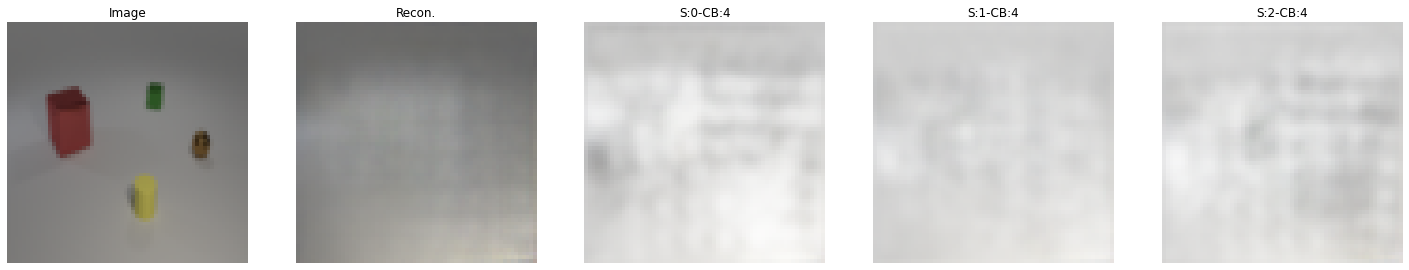

In [10]:
recon_combined, recons, masks, slots, cbidxs, qloss, perplexity = model.given_idxs(image, 
                                    torch.tensor([[4,4,4]]).to(device))
plot(image, recon_combined, recons, masks, cbidxs, num_slots=3)
    